# COVID-19 Response effect assessment





In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats  as stats
import seaborn as sns;
from matplotlib import ticker
import matplotlib.dates as mdates
from datetime import datetime
import calendar
import os
from os import listdir
from os.path import isfile, join
sns.set()

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)


## Pollution Data

Data collected from https://aqicn.org/

For each country, only one station from the most affected city (usually the capital) was considered.

*TODO: Get data from all stations in the city and take the averages*

Data from the 3 previous years were averaged to compute the daily baseline for pullution. Then, for co (industrial pollution) and no2 (fuel burning -- cars), the ratio between the 2020 data and the baseline was computed.

**co** is not used beuse few countries have these data

In [11]:
data_dir = 'data/'


df_orig_response = pd.read_csv(data_dir + 'pollution_countries_raw.csv', parse_dates = ['Date'])

# df_orig_response = df_orig_response.rename(columns={'date':'Date'})

df_orig_response.sample(10)

Country            City       Date        co        no2         o3       pm10        pm25       so2
521           France  All in dataset 2020-05-06  0.100000   4.674074  26.646154  12.814815   30.782609  0.862500
1259          Sweden  All in dataset 2020-03-19       NaN  10.550000  27.066667  15.500000   20.250000       NaN
293            China  All in dataset 2020-01-30  8.330769   8.605769  25.756522  53.038462  126.942308  5.573077
1333  United Kingdom  All in dataset 2020-01-22  2.925000  18.820000   5.755000  18.500000   57.500000  2.606667
855      Netherlands  All in dataset 2020-03-08  2.700000   5.154545  23.890909  13.363636   28.272727  0.333333
1336  United Kingdom  All in dataset 2020-01-25  3.142857  10.730000  12.100000  18.800000   54.900000  1.850000
191           Canada  All in dataset 2020-02-28  1.483333   5.700000  17.814286   6.000000   16.000000  0.700000
414           France  All in dataset 2020-01-20  0.100000  11.007407  17.872000  16.555556   38.913043  0.966667
789      Netherlands  All in dataset 2020-01-02  3.125000  10.718182   5.736364  18.909091   61.181818  0.450000
1212          Sweden  All in dataset 2020-02-01       NaN   6.600000  18.733333   8.000000   16.000000       NaN

## COVID cases and other statistics

Total confirmed cases and total deaths data from ourworldindata.org. Other statistics were derived fom the base data.



In [12]:
df_orig_cases = pd.read_csv(data_dir + 'total_cases_countries_normalized.csv', parse_dates = ['Date']).rename(columns={'Name':'Country'})

df_orig_cases.sample(10)

Country       Date    Total  Day  TotalDeaths  DailyDeaths  DailyCases  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyCasesPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
10388       Nepal 2020-01-03      0.0    3          0.0          0.0         0.0      0.000000            0.000000            0.000000           0.000000      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
15664  Uzbekistan 2020-03-26     65.0   86          0.0          0.0        10.0      0.197236            0.000000            0.000000           0.030344      1.0    1.181818               NaN      4.149238                 NaN    182.608696                 NaN
14911     Tunisia 2020-05-04   1013.0  125         42.0          0.0         4.0      8.759033            0.363158            0.000000           0.034587     44.0    1.003964          1.000000    175.192721            1.000000      6.743941           10.526316
10949     Nigeria 2020-01-07      0.0    7          0.0          0.0         0.0      0.000000            0.000000            0.000000           0.000000      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
3274        China 2020-04-18  83785.0  109       4636.0          0.0        31.0      6.015882            0.332871            0.000000           0.002226    104.0    1.000370          1.000000   1873.051357            1.000000      0.940919           38.677834
5747      Germany 2020-01-22      0.0   22          0.0          0.0         0.0      0.000000            0.000000            0.000000           0.000000      NaN         NaN               NaN           NaN                 NaN           NaN                 NaN
8663      Liberia 2020-03-22      3.0   82          0.0          0.0         1.0      0.062254            0.000000            0.000000           0.020751      NaN    1.500000               NaN      1.709511                 NaN           NaN                 NaN
5017     Ethiopia 2020-04-08     52.0   99          2.0          0.0         8.0      0.047608            0.001831            0.000000           0.007324      0.0    1.181818          1.000000      4.149238            1.000000    108.000000                 NaN
12979      Serbia 2020-04-23   7114.0  114        134.0          9.0       224.0    101.881762            1.919055            0.128892           3.207972     38.0    1.032511          1.072000     21.665190            9.969602     45.988098           35.353535
2859       Canada 2020-04-20  34777.0  111       1580.0        113.0      1436.0     93.845379            4.263614            0.304929           3.875031     44.0    1.043070          1.077028     16.437606            9.340933     42.733429          120.362622

In [13]:
df_orig = pd.merge(df_orig_response, df_orig_cases, how='left')

df_orig.tail()

Country            City       Date        co       no2         o3       pm10       pm25       so2      Total    Day  TotalDeaths  DailyDeaths  DailyCases  TotalPer100k  TotalDeathsPer100k  DailyDeathsPer100k  DailyCasesPer100k  DayNorm  GrowthRate  GrowthRateDeaths  DaysToDouble  DaysToDoubleDeaths  WeeklyGrowth  WeeklyGrowthDeaths
1567  United States  All in dataset 2020-05-04  2.443590  4.978947  26.003636  15.280000  24.732143  0.781250  1158041.0  125.0      67682.0       1297.0     24972.0    354.479739           20.717658            0.397015           7.644002     69.0    1.022039          1.019538     31.795882           35.823155     19.891191           23.336249
1568  United States  All in dataset 2020-05-05  2.234211  5.171053  25.036364  16.440000  24.053571  0.421429  1180634.0  126.0      68934.0       1252.0     22593.0    361.395522           21.100899            0.383241           6.915783     70.0    1.019510          1.018498     35.873845           37.816431     19.442845           22.560228
1569  United States  All in dataset 2020-05-06  2.445000  6.776316  25.972727  18.200000  21.785714  0.664286  1204475.0  127.0      71078.0       2144.0     23841.0    368.693322           21.757184            0.656285           7.297800     71.0    1.020193          1.031102     34.670872           22.630909     18.950743           21.802759
1570  United States  All in dataset 2020-05-07  2.415385  5.807895  27.905455  19.440000  25.000000  0.766667  1228603.0  128.0      73431.0       2353.0     24128.0    376.078973           22.477444            0.720260           7.385651     72.0    1.020032          1.033104     34.947486           21.282863     18.145242           20.445822
1571  United States  All in dataset 2020-05-08  2.104167  5.262500  26.474194  12.785714  27.060606  0.633333  1256972.0  129.0      75670.0       2239.0     28369.0    384.762807           23.162808            0.685364           8.683834     73.0    1.023090          1.030491     30.364033           23.077528     17.493125           20.099673

## Parameters

In [14]:
country = 'Brazil'
city = "São Paulo"
deaths_start = 10

date = 'bla'
df_to_show = df_orig[df_orig['Country'] == country][['Country', 'City', 'Date', 'no2', 'TotalDeaths']].sort_values('Date')

start_deaths = (df_to_show['TotalDeaths'] >= deaths_start).idxmax()

avg_before_deaths = df_to_show.loc[:start_deaths, 'no2'].mean()

start_display = max(start_deaths - 60, 0)

df_to_show = df_to_show.loc[start_display:, ]

df_to_show['no2'] = df_to_show[['no2']].rolling(5).mean()
df_to_show.head()


Country            City       Date       no2  TotalDeaths
22  Brazil  All in dataset 2020-01-21       NaN          0.0
23  Brazil  All in dataset 2020-01-22       NaN          0.0
24  Brazil  All in dataset 2020-01-23       NaN          0.0
25  Brazil  All in dataset 2020-01-24       NaN          0.0
26  Brazil  All in dataset 2020-01-25  5.513333          0.0

In [15]:
df_quar = pd.read_csv(data_dir + 'all_countries_response.csv', parse_dates = ['Quarantine']).replace(pd.NaT, np.nan)

quarantine = df_quar[df_quar['Country'] == country]['Quarantine'].iloc[0]

df_quar

code         Country       City Quarantine              Source                                               Link
0    FR          France      Paris 2020-03-17         Independent  https://www.independent.co.uk/news/world/europ...
1    BR          Brazil  São Paulo 2020-03-24  Folha de São Paulo  https://www1.folha.uol.com.br/equilibrioesaude...
2    IT           Italy      Milan 2020-03-08            euronews  https://www.euronews.com/2020/03/16/milan-unde...
3    US   United States  Manhattan 2020-03-20       New York Post  https://nypost.com/2020/03/20/how-long-will-ne...
4    ES           Spain     Madrid 2020-03-14                  as  https://en.as.com/en/2020/03/26/other_sports/1...
5    PT        Portugal     Lisbon 2020-03-18            euronews  https://www.euronews.com/2020/04/14/coronaviru...
6    CN           China      Wuhan 2020-01-23        John Hopkins  https://myemail.constantcontact.com/Update-on-...
7    DE         Germany     Berlin 2020-03-17          euobserver          https://euobserver.com/coronavirus/147754
8    GB  United Kingdom     London 2020-03-23        John Hopkins  https://myemail.constantcontact.com/COVID-19-U...
9    NL     Netherlands  Amsterdam 2020-03-15               metro  https://metro.co.uk/2020/03/15/netherlands-bec...
10   SE          Sweden  Stockholm        NaT        John Hopkins  https://myemail.constantcontact.com/COVID-19-U...
11   CA          Canada    Toronto 2020-04-02   national observer  https://www.nationalobserver.com/2020/04/02/ne...

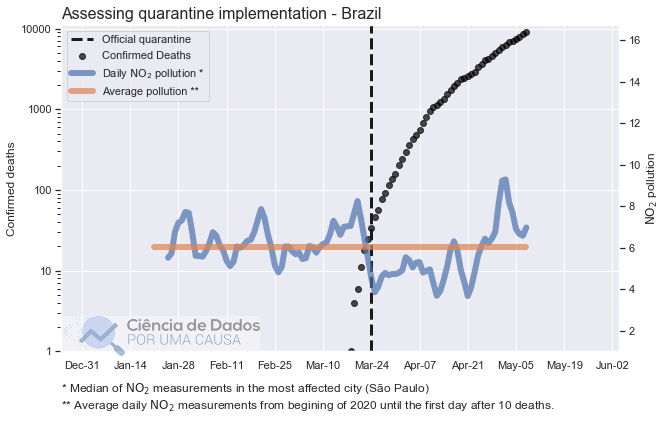

In [16]:
week = mdates.WeekdayLocator(interval=2)  # every year
months = mdates.MonthLocator()  # every month
month_fmt = mdates.DateFormatter('%b-%d')

y_lim = df_to_show['TotalDeaths'].max() * 1.2
y2_lim = df_to_show['no2'].max() * 1.8

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Assessing quarantine implementation - ' + country,
             fontsize=16,
             loc='left')

plt.scatter(df_to_show['Date'],
            df_to_show['TotalDeaths'],
            color='black',
            alpha=0.7,
            label='Confirmed Deaths')

ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(month_fmt)

ax.set_yscale('log')
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.set_ylim(1, y_lim)
ax.set(ylabel='Confirmed deaths')

plt.axvline(x=quarantine, color='k', linestyle='--', lw=3, label='Official quarantine')

ax2 = plt.twinx()

sns.lineplot(x="Date",
             y='no2',
             alpha=0.7,
             lw=6,
             label='Daily $\mathrm{{NO}}_2$ pollution *',
             ax=ax2,
             data=df_to_show)
sns.lineplot(x="Date",
             y=avg_before_deaths,
             alpha=0.7,
             lw=6,
             label='Average pollution **',
             ax=ax2,
             data=df_to_show)

ax2.grid(False)
ax2.xaxis.set_major_locator(week)
ax2.xaxis.set_major_formatter(month_fmt)
ax2.set_ylim(1, y2_lim)
ax2.set(ylabel='$\mathrm{{NO}}_2$ pollution')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

annotation = """* Median of $\mathrm{{NO}}_2$ measurements in the most affected city ({city}) 
** Average daily $\mathrm{{NO}}_2$ measurements from begining of 2020 until the first day after {deaths_start} deaths.""".format(
    city=city, deaths_start=deaths_start)
ax.annotate(annotation, (0, 0), (0, -30),
            xycoords='axes fraction',
            textcoords='offset points',
            va='top')

logo = plt.imread('img/new_logo_site.png')
ax.figure.figimage(logo, 60, 65, alpha=.35, zorder=1)

In [17]:
def show_response_country(country, deaths_start, df_to_show):
    city = df_to_show['City'].iloc[0]
    df_quar = pd.read_csv(data_dir + 'all_countries_response.csv', parse_dates = ['Quarantine'])
    quarantine = df_quar[df_quar['Country'] == country]['Quarantine'].iloc[0]
    
    week = mdates.WeekdayLocator(interval=2)   # every year
    months = mdates.MonthLocator()  # every month
    month_fmt = mdates.DateFormatter('%b-%d')

    y_lim = df_to_show['TotalDeaths'].max() * 1.2
    y2_lim = df_to_show['no2'].max() * 1.8

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title('Assessing quarantine implementation - ' + country, fontsize=16, loc='left')
    
    if not pd.isnull(quarantine): plt.axvline(x=quarantine, color='k', linestyle='--', lw=3, label='Official quarantine')

    plt.scatter(df_to_show['Date'], df_to_show['TotalDeaths'], color='black', alpha = 0.7, label = 'Confirmed Deaths')

    ax.xaxis.set_major_locator(week)
    ax.xaxis.set_major_formatter(month_fmt)

    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.set_ylim(1, y_lim)
    ax.set(ylabel='Confirmed deaths')

    ax2 = plt.twinx()

    sns.lineplot(x="Date", y='no2',  alpha = 0.7, lw = 6, label = 'Daily $\mathrm{{NO}}_2$ pollution *', ax=ax2, data=df_to_show)
    sns.lineplot(x="Date", y=avg_before_deaths,  alpha = 0.7, lw = 6, label = 'Average pollution **', ax=ax2, data=df_to_show)

    ax2.grid(False)
    ax2.xaxis.set_major_locator(week)
    ax2.xaxis.set_major_formatter(month_fmt)
    ax2.set_ylim(1, y2_lim)
    ax2.set(ylabel='$\mathrm{{NO}}_2$ pollution')

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    annotation = """* Median of $\mathrm{{NO}}_2$ measurements in the most affected city ({city}), 5 days rolling average over time series\n** Average daily $\mathrm{{NO}}_2$ measurements from the begining of 2020 until the first day after {deaths_start} deaths""".format(city=city, deaths_start = deaths_start) 
    ax.annotate(annotation, (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top')

    logo = plt.imread('img/new_logo_site.png')
    ax.figure.figimage(logo, 60, 75, alpha=.35, zorder=1)
    plt.savefig('quarantine-impl-' + country + '.svg')
    plt.show()

Brazil


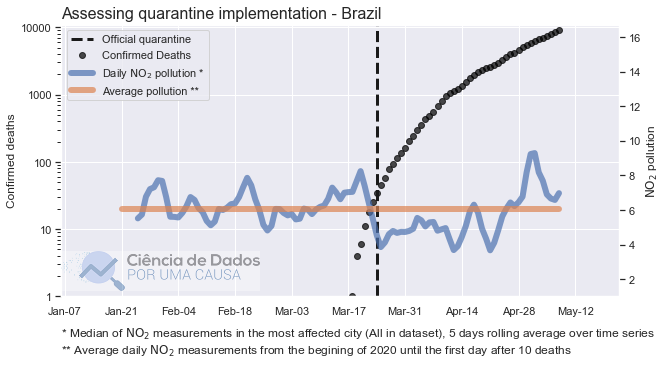

Canada


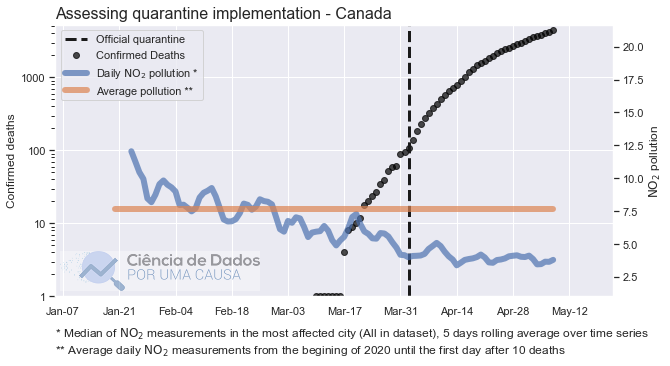

China


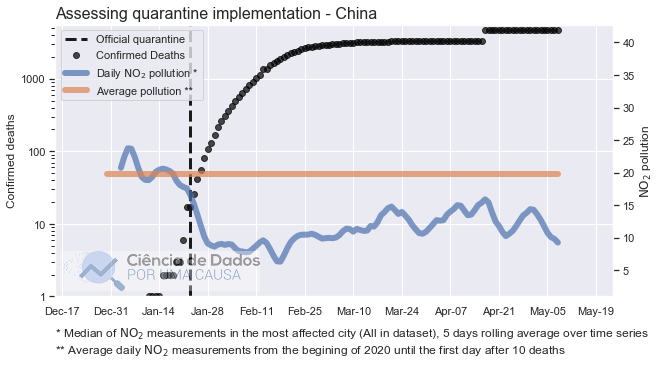

France


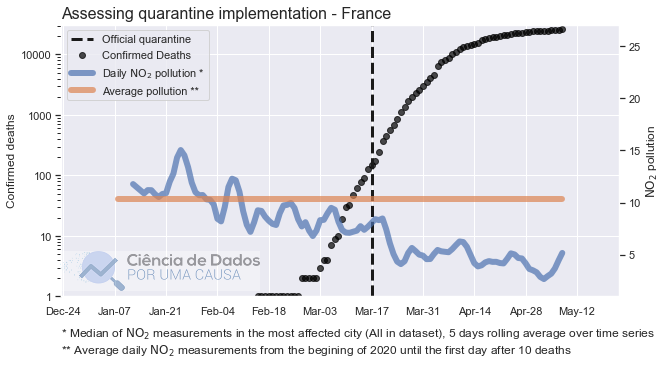

Germany


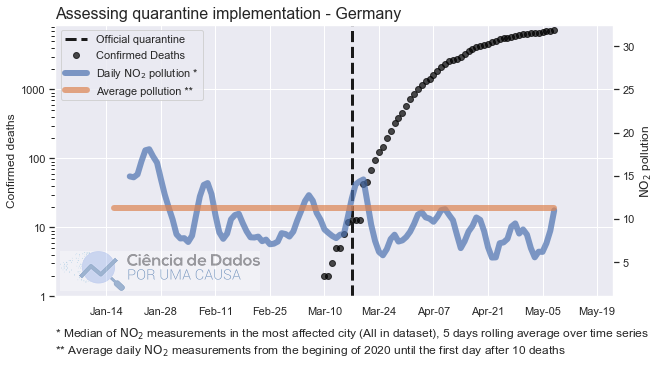

Italy


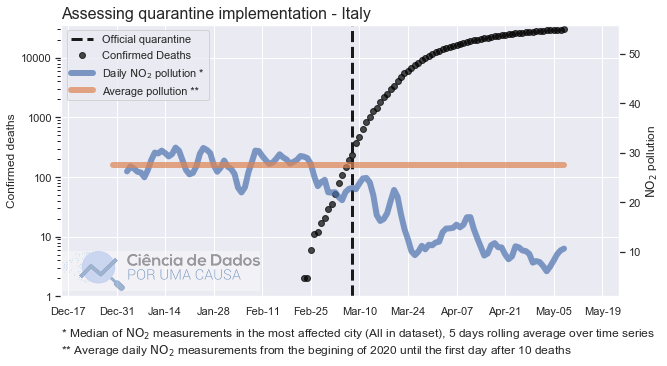

Netherlands


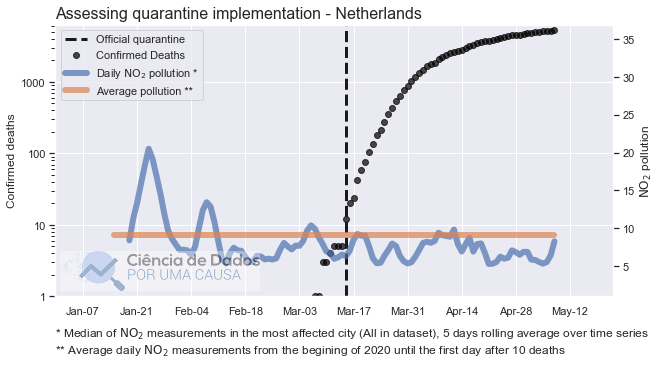

Portugal


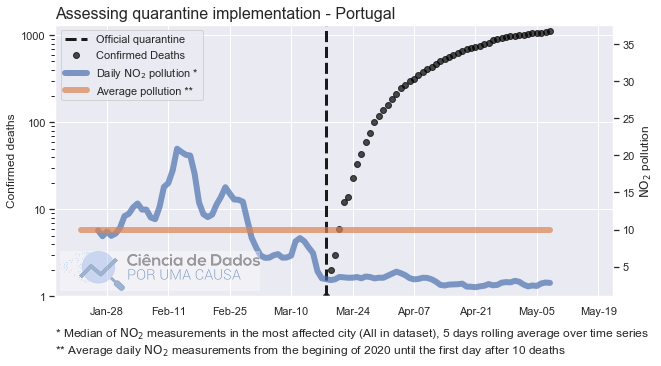

Spain


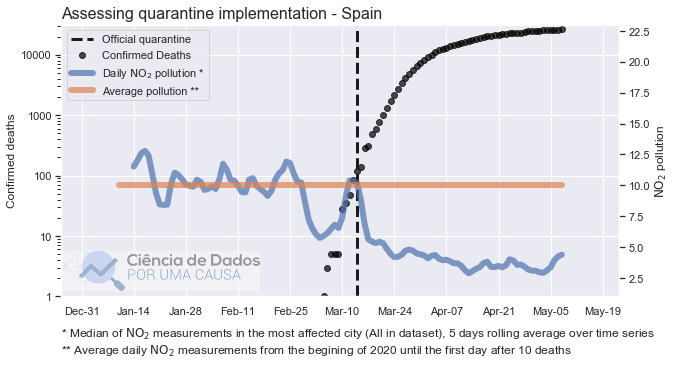

Sweden


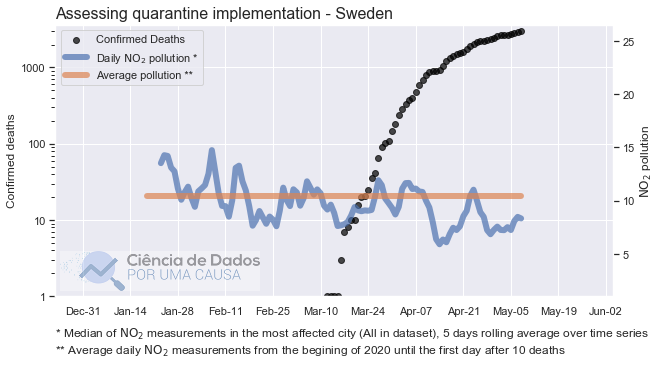

United Kingdom


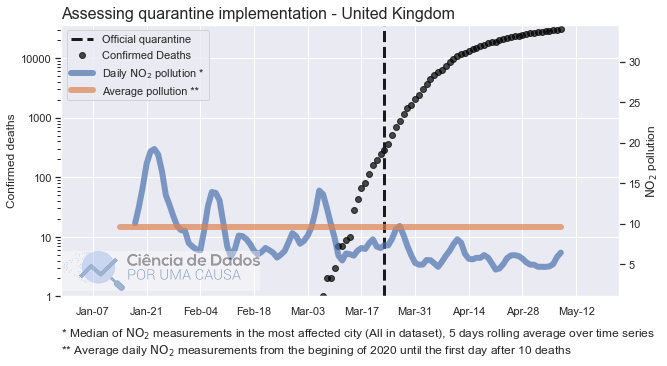

United States


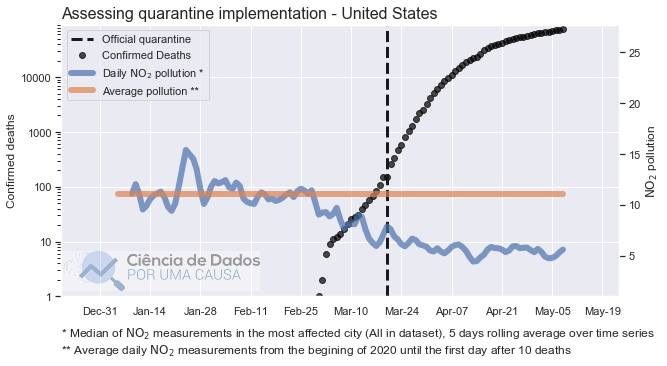

In [18]:
for country in df_orig_response['Country'].unique():
    print(country)
    df_to_show = df_orig[df_orig['Country'] == country][['Country', 'City', 'Date', 'no2', 'TotalDeaths']].sort_values('Date')

    deaths_start = 10
    start_deaths = (df_to_show['TotalDeaths'] >= deaths_start).idxmax()

    avg_before_deaths = df_to_show.loc[:start_deaths, 'no2'].mean()

    start_display = max(start_deaths - 60, 0)

    df_to_show = df_to_show.loc[start_display:, ]

    df_to_show['no2'] = df_to_show[['no2']].rolling(5).mean()
    
    show_response_country(country, deaths_start, df_to_show)

